**Write the names of all group members (max. 5 members)**:
- Lucas, Gimeno
- Nils, Johnson
- Hai Yen, Van
- Matteo, Bodmer
- Jonas, Isler

When submitting your work, please follow closely the template below.

# Exercise 1 (Poisson GLM)

### Question 1.a

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Detect device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


In [3]:
# Set random seeds for reproducibility
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Additional settings for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seeds set to {SEED} for reproducibility")

Random seeds set to 42 for reproducibility


In [4]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
# Use semicolon separator and comma decimal (common for this dataset)
dataframe = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',', encoding='utf-8')
print(dataframe.head())
# extracrt features X and target y from the dataframe
X_full = dataframe[["VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]]
y_full = dataframe[["Exposure", "ClaimNb"]]
y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]
# print data sizes
print(f'head of X (full dataset) is {X_full.head()} with sieze {X_full.shape}')
print(f'head of y (full dataset) is {y_full.head()} with sieze {y_full.shape}')

   VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region  \
0         4       9       23         100       B6  Regular     7887    R31   
1         4       6       26         100       B6  Regular     2308    R31   
2         4       6       26         100       B6  Regular     2308    R31   
3         7       4       44          50       B6  Regular       37    R94   
4         5       2       29          90       B6  Regular      335    R91   

   Exposure  ClaimNb  
0      0.76        0  
1      0.74        0  
2      0.11        0  
3      0.83        0  
4      0.69        0  
head of X (full dataset) is    VehPower  VehAge  DrivAge  BonusMalus VehBrand   VehGas  Density Region
0         4       9       23         100       B6  Regular     7887    R31
1         4       6       26         100       B6  Regular     2308    R31
2         4       6       26         100       B6  Regular     2308    R31
3         7       4       44          50       B6  Regular       

C:\Users\Lucas\AppData\Local\Temp\ipykernel_5112\2005146420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_full["ClaimFrequency"] = y_full["ClaimNb"]/y_full["Exposure"]


In [5]:
# One-hot encode categorical variables and standardize numeric features on full data
categorical_cols = ['VehBrand', 'VehGas', 'Region']
numeric_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Create dummies for categorical variables (done on full data to ensure consistent columns)
X_encoded = pd.get_dummies(X_full, columns=categorical_cols, drop_first=False)
print(f'X_encoded shape after encoding: {X_encoded.shape}')

# Standardize numeric columns on full data
X_scaler = StandardScaler()
X_encoded[numeric_cols] = X_scaler.fit_transform(X_encoded[numeric_cols])
print(f'X_encoded shape after standardization: {X_encoded.shape}')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_full, test_size=0.1, random_state=42)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

# Train a Poisson GLM
# You can use sklearn.linear_model.PoissonRegressor
glm = PoissonRegressor(alpha=0.0) # intercept is True by default
glm.fit(X_train, y_train["ClaimFrequency"], sample_weight=y_train["Exposure"])
# Print MAE, MSE and loss on train and test data sets
print("average MARE on train:", mean_absolute_error(y_train["ClaimFrequency"], glm.predict(X_train), sample_weight=y_train["Exposure"]))
print("average MSE on train:", mean_squared_error(y_train["ClaimFrequency"], glm.predict(X_train), sample_weight=y_train["Exposure"]))
print("mean Poisson deviance on test data: %.3f" % mean_poisson_deviance (y_train['ClaimFrequency'], glm.predict(X_train), sample_weight=y_train['Exposure']))



X_encoded shape after encoding: (678007, 40)
X_encoded shape after standardization: (678007, 40)
X_train shape: (610206, 40), X_test shape: (67801, 40)
average MARE on train: 0.13828499965098284
average MSE on train: 0.23555100657378364
mean Poisson deviance on test data: 0.459


In [6]:
# Test Set, sample_weight=y_test["Exposure"]
# Print MAE, MSE and loss on train and test data sets
print("average MARE on test:", mean_absolute_error(y_test["ClaimFrequency"], glm.predict(X_test), sample_weight=y_test["Exposure"]))
print("average MSE on test:", mean_squared_error(y_test["ClaimFrequency"], glm.predict(X_test), sample_weight=y_test["Exposure"]))
print("mean Poisson deviance on test data: %.3f" % mean_poisson_deviance (y_test['ClaimFrequency'], glm.predict(X_test), sample_weight=y_test['Exposure']))

average MARE on test: 0.13631781211060318
average MSE on test: 0.25533735537453645
mean Poisson deviance on test data: 0.451


### Question 1.b

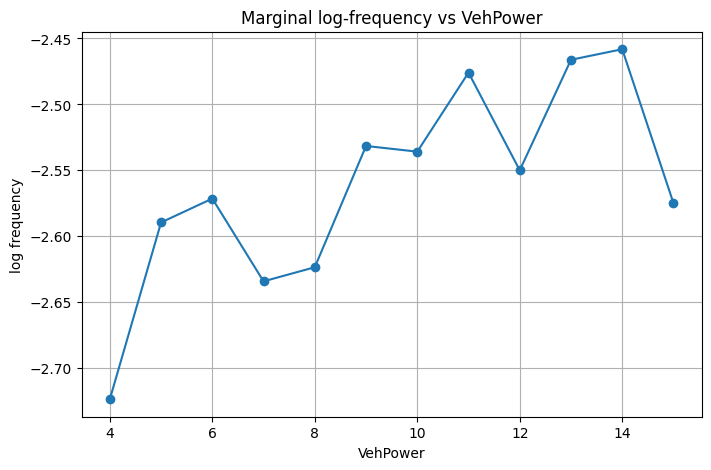

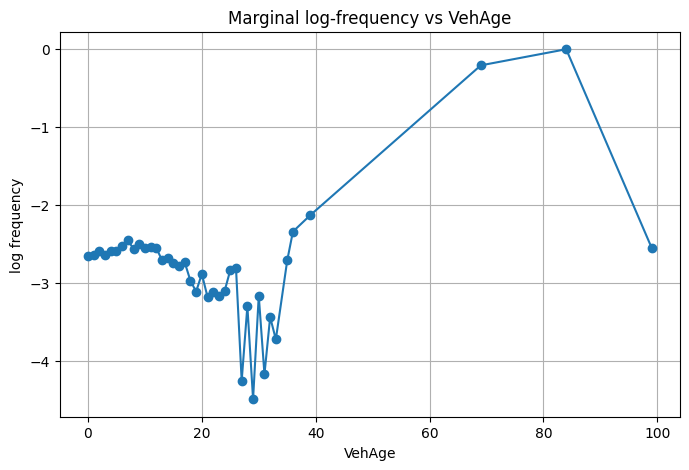

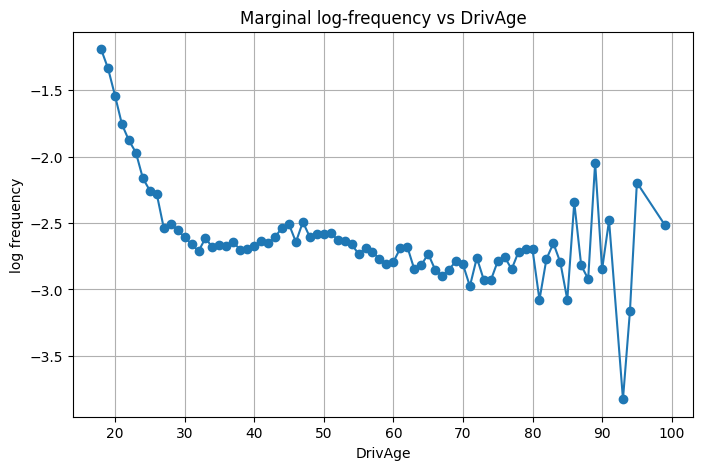

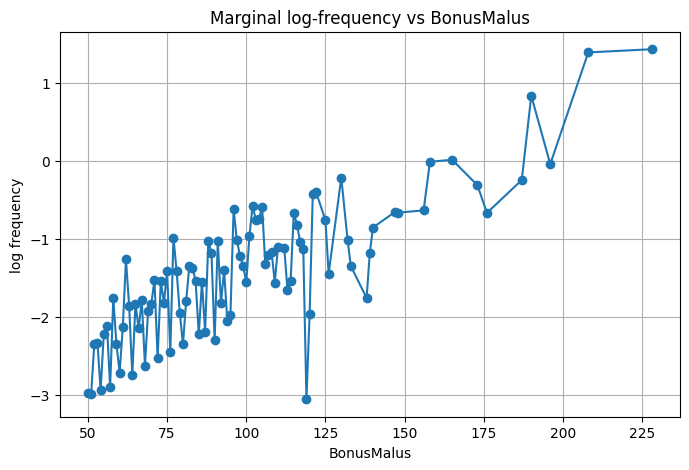

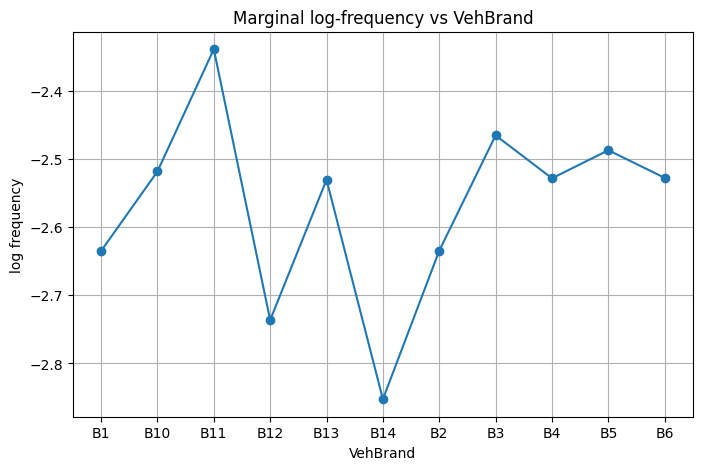

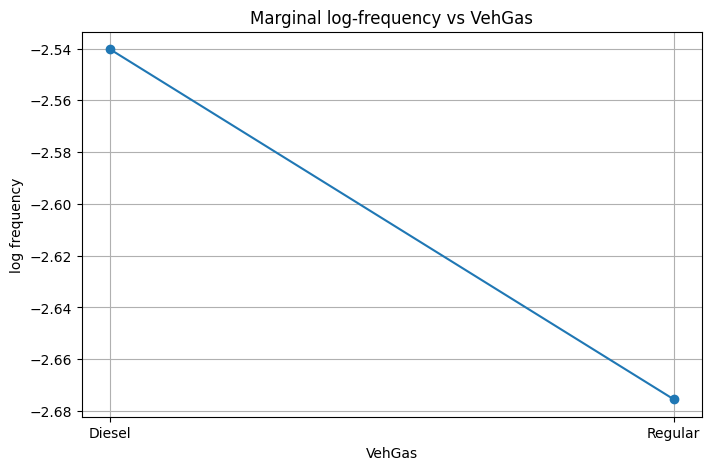

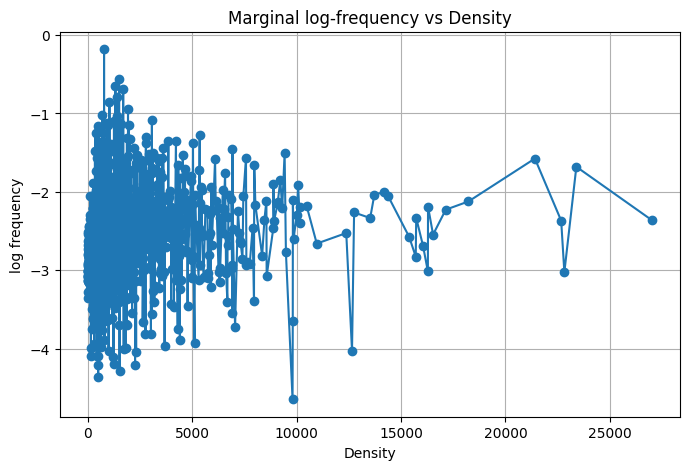

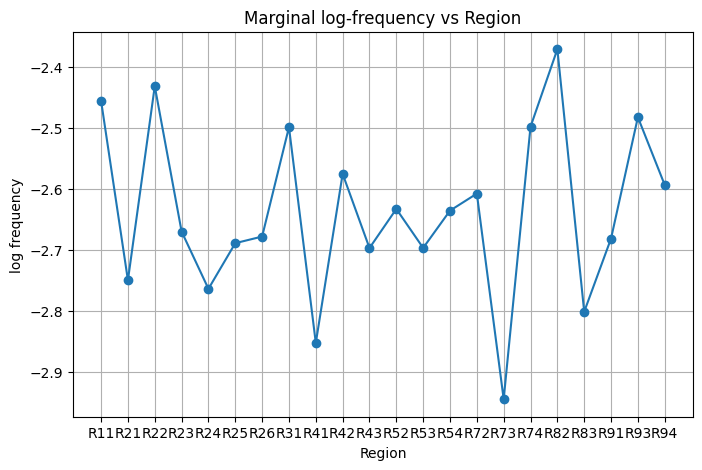

In [7]:
# Plot the empirical marginal log-frequencies
df = pd.concat([X_full, y_full], axis=1)
df = df[df["Exposure"] > 0]
features = X_full.columns

for feature in features:
    grouped = df.groupby(feature).agg({
        "ClaimNb": "sum",
        "Exposure": "sum"
    })

    # empirical frequency
    grouped["freq"] = grouped["ClaimNb"] / grouped["Exposure"]

    # remove zero-frequencies before log
    grouped = grouped[grouped["freq"] > 0]

    # log-frequency
    grouped["log_freq"] = np.log(grouped["freq"])

    # ---- Plot ----
    plt.figure(figsize=(8, 5))
    plt.plot(grouped.index, grouped["log_freq"], marker='o')
    plt.title(f"Marginal log-frequency vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("log frequency")
    plt.grid(True)
    plt.show()

In [8]:
# Propose feature transformations. Justify your choices

### Question 1.c

In [9]:
# Train a Poisson GLM using your feature transformations

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the model of Question 1.a

# Exercise 2 (Poisson FNN)

### Question 2.a

In [57]:
# Neural network implementation

# Poisson Neural Network: ReLU hidden layers + exponential output
class PoissonNN(torch.nn.Module):
    """
    Feedforward neural network for Poisson regression.

    The constructor accepts either:
    - an int `n_neurons_per_layer` together with `n_layers` to create `n_layers` hidden layers
      each having `n_neurons_per_layer` neurons, or
    - a list/tuple `n_neurons_per_layer` containing the number of neurons per hidden layer.

    The final layer uses an exponential activation so the network predicts positive Poisson means.
    """
    def __init__(self, input_dim, output_dim, n_neurons_per_layer=128, n_layers=2):
        super(PoissonNN, self).__init__()

        # Normalize n_neurons_per_layer into a list `sizes`
        if isinstance(n_neurons_per_layer, int):
            sizes = [int(n_neurons_per_layer)] * int(n_layers)
        elif isinstance(n_neurons_per_layer, (list, tuple)):
            sizes = [int(s) for s in n_neurons_per_layer]
            if n_layers is not None and len(sizes) != int(n_layers):
                raise ValueError("If providing a list for n_neurons_per_layer, n_layers must be None or match its length")
        else:
            raise TypeError("n_neurons_per_layer must be int or list/tuple of ints")

        self.relu = torch.nn.ReLU()
        
        # Handle case with zero hidden layers
        if len(sizes) == 0:
            # No hidden layers: map input directly to output
            self.input_layer = None
            last_size = input_dim
            self.hidden_layers = torch.nn.ModuleList()
        else:
            # First hidden layer (from input)
            self.input_layer = torch.nn.Linear(input_dim, sizes[0])
            # Subsequent hidden layers
            self.hidden_layers = torch.nn.ModuleList(
                [torch.nn.Linear(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]
            )
            last_size = sizes[-1]

        # Final decoder to output
        self.decoder = torch.nn.Linear(last_size, output_dim)
        self.layer_norm = torch.nn.LayerNorm(last_size)

    def forward(self, x):
        # If there are hidden layers, pass through them using ReLU
        if self.input_layer is not None:
            x = self.relu(self.input_layer(x))
            for layer in self.hidden_layers:
                x = self.relu(layer(x))
        # Directly decode if no hidden layers
        # add normalizaton layer to bound outputs
        # x = self.layer_norm(x)
        x = torch.exp(self.decoder(x))
        # exponential activation to ensure positive Poisson mean
        return x


#Model instantiation (adapt N and M to data dimensions)
N = X_encoded.shape[1]  # number of input features
print(f"Number of input features: {N}")
M = 1                    # number of output targets (ClaimFrequency/Exposure)
# Example using a list of neurons per layer
test_model = PoissonNN(input_dim=N, output_dim=M, n_neurons_per_layer=[128, 64, 32], n_layers=3)
print(f"PoissonNN model created with input_dim={N}, output_dim={M}")
print(f"\nPoissonNN architecture:\n{test_model}")


# model factory for poisson trainer
def poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=20, n_layers=2):
    return PoissonNN(input_dim=input_dim, output_dim=output_dim, n_neurons_per_layer=n_neurons_per_layer, n_layers=n_layers)


Number of input features: 40
PoissonNN model created with input_dim=40, output_dim=1

PoissonNN architecture:
PoissonNN(
  (relu): ReLU()
  (input_layer): Linear(in_features=40, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Linear(in_features=32, out_features=1, bias=True)
  (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
)


### Question 2.b

In [58]:
# Train Poisson feedforward neural network model

from tqdm import tqdm

# Detect GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

X_train_tensor = torch.tensor(X_train.to_numpy(dtype=np.float32))
X_test_tensor = torch.tensor(X_test.to_numpy(dtype=np.float32))
y_train_tensor = torch.tensor(y_train["ClaimFrequency"].to_numpy(dtype=np.float32).reshape(-1, 1))
y_test_tensor = torch.tensor(y_test["ClaimFrequency"].to_numpy(dtype=np.float32).reshape(-1, 1))
exposure_train_tensor = torch.tensor(y_train["Exposure"].to_numpy(dtype=np.float32))
exposure_test_tensor = torch.tensor(y_test["Exposure"].to_numpy(dtype=np.float32))

print(f'type of X_train_tensor: {type(X_train_tensor)}, shape: {X_train_tensor.shape}')

# ============================================
#   PREPARE DATA (dataset_train is TensorDataset)
# ============================================
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device).squeeze()
y_test_tensor = y_test_tensor.to(device).squeeze()
exposure_train_tensor = exposure_train_tensor.to(device)
exposure_test_tensor = exposure_test_tensor.to(device)



Using device: cuda

type of X_train_tensor: <class 'torch.Tensor'>, shape: torch.Size([610206, 40])


In [59]:

# ============================================
#   CUSTOM LOSS
# ============================================

def loss_fn(lam, y, exposure):
    # add tiny eps for numerical stability
    eps = 1e-8
    # term1 = y * log(lam), zero where lam==0
    term1 = torch.where(y > 0, y * torch.log(lam), torch.zeros_like(y))
    # term2 = y * log(y), zero where y==0
    term2 = torch.where(y > 0, y * torch.log(y), torch.zeros_like(y))

    # Poisson deviance
    dev = 2.0 * (lam - y - term1 + term2)

    # exposure-weighted mean
    loss = torch.sum(exposure * dev) / (torch.sum(exposure) + eps)
    return loss




In [60]:
class PoissonTrainer:
    def __init__(self, model_factory, loss_fn=loss_fn, lr=1e-2, batch_size=10000, n_epochs=100,
                 milestones=[], n = N, sub_frac = 0.7, n_estimatiors=5):
        """
        Trainer for Poisson GLMs or neural networks using a custom loss.

        Parameters added:
        - use_amp: enable mixed-precision training with torch.cuda.amp (recommended on GPU)
        - use_compile: try to use torch.compile() if available (PyTorch 2.0+)
        """
        # Detect device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[INFO] Using device: {self.device}")

        # Store parameters
        self.model_factory = model_factory
        self.loss_fn = loss_fn
        self.lr = lr
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.milestones = milestones
        self.n = n
        self.n_estimators = n_estimatiors # amount of submodels in ensemble
        self.sub_frac = sub_frac # subbagging fraction
        self.input_dim = n
        self.output_dim = 1
        # regularization
        self.lam_1 = 0.0 # L1 regularizer
        self.lam_2 = 0.0 # L2 regularizer
        self.alpha = 0.0 # elastic net mixing parameter
        self.l1_ratio = 0.0 # l1 ratio for elastic net
        self.regularizer = None

        # Will store per-submodel epoch loss histories as a list of lists
        self.epoch_losses = []

    # ------------------------------------------------------------
    # TRAIN METHOD
    # ------------------------------------------------------------
    def train(self, X, y, exposure):
        n = X.shape[0]
        n_sub = int(self.sub_frac * n)

        # Pre-sample indices
        idx_list = [torch.randperm(n, device=self.device)[:n_sub] 
                    for _ in range(self.n_estimators)]

        # Pre-create subsampled datasets
        subsamples = []
        for idx in idx_list:
            X_sub = X[idx].contiguous()
            y_sub = y[idx].contiguous()
            e_sub = exposure[idx].contiguous()
            subsamples.append((X_sub, y_sub, e_sub))

        # Create models
        self.models = [self.model_factory(self.input_dim, self.output_dim).to(self.device) 
                    for _ in range(self.n_estimators)]

        optimizers = [torch.optim.AdamW(m.parameters(), lr=self.lr) for m in self.models]
        schedulers = [torch.optim.lr_scheduler.MultiStepLR(opt, milestones=self.milestones, gamma=0.1) 
                    for opt in optimizers]

        for i in range(self.n_estimators):
            print(f"\n[Training submodel {i+1}/{self.n_estimators}]")
            model = self.models[i]
            optimizer = optimizers[i]
            scheduler = schedulers[i]
            X_sub, y_sub, e_sub = subsamples[i]

            model.train()
            epoch_losses_sub = []

            loop = tqdm(range(self.n_epochs))
            for epoch in loop:
                perm = torch.randperm(n_sub, device=self.device)
                running_loss = 0.0
                n_batches = 0
                for j in range(0, n_sub, self.batch_size):
                    idx = perm[j:j + self.batch_size]
                    
                    lam = model(X_sub[idx]).squeeze()
                    loss = self.loss_fn(lam, y_sub[idx], e_sub[idx])

                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                
                    running_loss += loss.detach()
                    n_batches += 1

                avg_loss = running_loss.item() / n_batches
                epoch_losses_sub.append(avg_loss)
                loop.set_postfix(loss=avg_loss)
                scheduler.step()

            self.epoch_losses.append(epoch_losses_sub)

            # Move the trained submodel to CPU to free GPU memory and clear cache
            # This helps prevent GPU memory from accumulating when training ensembles
            self.models[i] = model.to("cpu")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # ------------------------------------------------------------
    # EVALUATION METHOD
    # ------------------------------------------------------------

    def predict(self, X):
        X = X.to(self.device)

        with torch.no_grad():
            preds = torch.stack([
                m.to(self.device)(X).squeeze()
                for m in self.models
            ])

        return preds.mean(dim=0)

    def evaluate(self, X_train, y_train, exposure_train,
                 X_test, y_test, exposure_test, verbose=False):

        # ---- Aggregated predictions (torch tensors on device) ----
        lam_train = self.predict(X_train)
        lam_test  = self.predict(X_test)

        # ---- Prepare tensors on the correct device for Torch loss computation ----
        # The inputs (y/exposure) may be numpy arrays, CPU tensors or GPU tensors.
        # Ensure torch loss receives tensors on self.device to avoid device-mismatch errors.
        def to_device_tensor(x, dtype=None):
            if isinstance(x, torch.Tensor):
                return x.to(self.device)
            # preserve dtype if possible, else fall back to lam_train dtype
            dtype = dtype if dtype is not None else lam_train.dtype
            return torch.as_tensor(x, device=self.device, dtype=dtype)

        y_train_dev = to_device_tensor(y_train, dtype=lam_train.dtype)
        y_test_dev = to_device_tensor(y_test, dtype=lam_test.dtype)
        exp_train_dev = to_device_tensor(exposure_train, dtype=lam_train.dtype)
        exp_test_dev = to_device_tensor(exposure_test, dtype=lam_test.dtype)

        # ---- Torch loss (exposure-weighted Poisson deviance) ----
        train_poi_dev = self.loss_fn(lam_train.to(self.device), y_train_dev, exp_train_dev).item()
        test_poi_dev  = self.loss_fn(lam_test.to(self.device), y_test_dev, exp_test_dev).item()

        # ---- Helper: convert tensors (or arrays) to numpy on CPU ----
        def to_numpy(x):
            if isinstance(x, torch.Tensor):
                return x.detach().cpu().numpy()
            return np.asarray(x)

        # ---- Convert targets & preds to numpy for sklearn metrics ----
        y_train_np = to_numpy(y_train)
        y_test_np  = to_numpy(y_test)
        exp_train_np = to_numpy(exposure_train)
        exp_test_np  = to_numpy(exposure_test)
        lam_train_np = to_numpy(lam_train)
        lam_test_np  = to_numpy(lam_test)

        # ---- Metrics ----
        if verbose:
            print("=== TRAIN METRICS ===")
            print("MAE:", mean_absolute_error(y_train_np, lam_train_np, sample_weight=exp_train_np))
            print("MSE:", mean_squared_error(y_train_np, lam_train_np, sample_weight=exp_train_np))
            print("Exposure-weighted Poisson deviance (Sklearn):",
                mean_poisson_deviance(y_train_np, lam_train_np, sample_weight=exp_train_np))
            print("Exposure-weighted Poisson deviance (Torch custom):", train_poi_dev)

            print("\n=== TEST METRICS ===")
            print("MAE:", mean_absolute_error(y_test_np, lam_test_np, sample_weight=exp_test_np))
            print("MSE:", mean_squared_error(y_test_np, lam_test_np, sample_weight=exp_test_np))
            print("Exposure-weighted Poisson deviance (Sklearn):",
                mean_poisson_deviance(y_test_np, lam_test_np, sample_weight=exp_test_np))
            print("Exposure-weighted Poisson deviance (Torch custom):", test_poi_dev)

        return {
            "train": {
                "mae": mean_absolute_error(y_train_np, lam_train_np, sample_weight=exp_train_np),
                "mse": mean_squared_error(y_train_np, lam_train_np, sample_weight=exp_train_np),
                "dev_sklearn": mean_poisson_deviance(y_train_np, lam_train_np, sample_weight=exp_train_np),
                "dev_torch": train_poi_dev
            },
            "test": {
                "mae": mean_absolute_error(y_test_np, lam_test_np, sample_weight=exp_test_np),
                "mse": mean_squared_error(y_test_np, lam_test_np, sample_weight=exp_test_np),
                "dev_sklearn": mean_poisson_deviance(y_test_np, lam_test_np, sample_weight=exp_test_np),
                "dev_torch": test_poi_dev
            }
        }

    # ------------------------------------------------------------
    # LOSS-PLOT METHOD
    # ------------------------------------------------------------
    def plot_losses(self):
        if not self.epoch_losses:
            print("No loss history recorded yet. Run `train()` first.")
            return

        plt.figure(figsize=(10, 6))

        # If epoch_losses is a list of per-submodel lists, plot each
        if isinstance(self.epoch_losses[0], (list, tuple, np.ndarray)):
            for i, losses in enumerate(self.epoch_losses):
                plt.plot(losses, label=f"submodel_{i+1}")
        else:
            plt.plot(self.epoch_losses, label="loss")

        plt.xlabel("Epoch")
        plt.ylabel("Exposure-weighted Poisson deviance")
        plt.title("Training Loss per Epoch (per submodel)")
        plt.grid(True)
        plt.legend()
        plt.show()

    # ------------------------------------------------------------
    # FREE GPU
    # ------------------------------------------------------------
    def free_gpu(self):
        # Move all stored models to CPU
        for i, m in enumerate(self.models):
            self.models[i] = m.to("cpu")
        torch.cuda.empty_cache()

In [ ]:
n_hidden_layers = [0, 1, 2]
n_neurons = [16, 32]

# Collect test metrics for each configuration
results = []

for n_layers in n_hidden_layers:
    for n_neuron in n_neurons:
        print(f"Training with {n_layers} hidden layers and {n_neuron} neurons per layer")
        # Use default args in lambda to capture loop variables correctly
        standardTrainer = PoissonTrainer(
            model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=nn, n_layers=nl),
            n_epochs=100, lr=1e-2, sub_frac=0.1, n_estimatiors=5
        )
        standardTrainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
        metrics = standardTrainer.evaluate(
            X_train_tensor, y_train_tensor, exposure_train_tensor,
            X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=False
        )

        # Append test metrics
        results.append({
            'n_layers': n_layers,
            'n_neurons': n_neuron,
            'mae': metrics['test']['mae'],
            'mse': metrics['test']['mse'],
            'dev_sklearn': metrics['test']['dev_sklearn'],
            'dev_torch': metrics['test']['dev_torch']
        })

        standardTrainer.plot_losses()
        standardTrainer.free_gpu()


In [52]:
# Create a nice summary table of results
df_results = pd.DataFrame(results)
# Round metrics for display
for c in ['mae', 'mse', 'dev_sklearn', 'dev_torch']:
    df_results[c] = df_results[c].astype(float).round(6)
# Sort table for readability
df_results = df_results.sort_values(['n_layers', 'n_neurons']).reset_index(drop=True)
print("\n=== SUMMARY OF TEST METRICS ===")
print(df_results.to_string(index=False))


=== SUMMARY OF TEST METRICS ===
 n_layers  n_neurons      mae      mse  dev_sklearn  dev_torch
        0         16 0.137423 0.255298     0.452619   0.452619
        0         32 0.137629 0.255298     0.452716   0.452716
        1         16 0.135121 0.254562     0.446667   0.446667
        1         32 0.132552 0.254570     0.445810   0.445810
        2         16 0.142320 0.254547     0.447237   0.447237
        2         32 0.130597 0.255061     0.450360   0.450360


We can see that 1 hidden layer with 16 neurons performed best, we will try this architecture for the next steps. We will make this rough comparison now (instead of full cross-validation) and then fully cross-validate to fing the optimal regularization parameters. 

  1         16 0.134950 0.255285     0.454214   0.454214 # 200 epoch 0.01 frac 10 models
 1          32 0.136176 0.255260     0.453357   0.453357  # 100 epoch "  "
 1          32 0.134963 0.254653     0.445068   0.445068 # 100 epoch 0.1 frac 5 models ==> winner


[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 200/200 [00:02<00:00, 80.84it/s, loss=0.425]



[Training submodel 2/5]


100%|██████████| 200/200 [00:02<00:00, 79.84it/s, loss=0.445]



[Training submodel 3/5]


100%|██████████| 200/200 [00:02<00:00, 82.33it/s, loss=0.423]



[Training submodel 4/5]


100%|██████████| 200/200 [00:03<00:00, 64.91it/s, loss=0.424]



[Training submodel 5/5]


100%|██████████| 200/200 [00:03<00:00, 59.92it/s, loss=0.41] 


=== TRAIN METRICS ===
MAE: 0.14013436436653137
MSE: 0.23552925884723663
Exposure-weighted Poisson deviance (Sklearn): 0.45307761430740356
Exposure-weighted Poisson deviance (Torch custom): 0.4530775845050812

=== TEST METRICS ===
MAE: 0.13862982392311096
MSE: 0.2582840919494629
Exposure-weighted Poisson deviance (Sklearn): 0.448772132396698
Exposure-weighted Poisson deviance (Torch custom): 0.4487720727920532


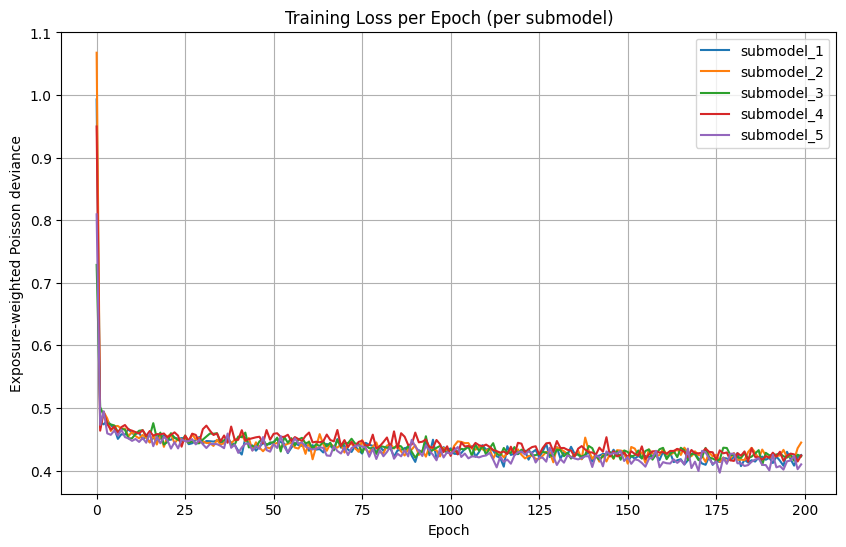

In [47]:
L2Trainer = PoissonTrainer(model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=32, n_layers=1), n_epochs=200, lr=1e-2, sub_frac=0.1, n_estimatiors=5)
L2Trainer.lam_2 = 1.0  # set L2 regularization strength
L2Trainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
L2Trainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
L2Trainer.plot_losses()

[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 200/200 [00:02<00:00, 77.07it/s, loss=0.435]



[Training submodel 2/5]


100%|██████████| 200/200 [00:02<00:00, 78.23it/s, loss=0.413]



[Training submodel 3/5]


100%|██████████| 200/200 [00:02<00:00, 81.69it/s, loss=0.435]



[Training submodel 4/5]


100%|██████████| 200/200 [00:02<00:00, 83.70it/s, loss=0.424]



[Training submodel 5/5]


100%|██████████| 200/200 [00:02<00:00, 82.41it/s, loss=0.414]


=== TRAIN METRICS ===
MAE: 0.13889791071414948
MSE: 0.23519748449325562
Exposure-weighted Poisson deviance (Sklearn): 0.453217476606369
Exposure-weighted Poisson deviance (Torch custom): 0.45321741700172424

=== TEST METRICS ===
MAE: 0.13699665665626526
MSE: 0.25525081157684326
Exposure-weighted Poisson deviance (Sklearn): 0.44751501083374023
Exposure-weighted Poisson deviance (Torch custom): 0.44751492142677307


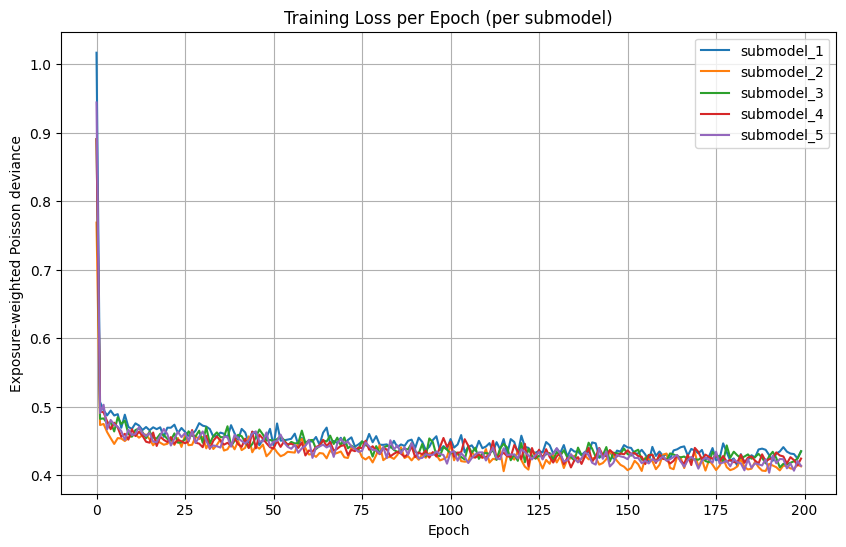

In [48]:
 # L1 Test
model = PoissonNN(input_dim=N, output_dim=M)
L1Trainer = PoissonTrainer(model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=32, n_layers=1), n_epochs=200, lr=1e-2, sub_frac=0.1, n_estimatiors=5)
L1Trainer.lam_1 = 0.01  # Set L1 regularization parameter
L1Trainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
L1Trainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
L1Trainer.plot_losses()

[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 73.16it/s, loss=0.435]



[Training submodel 2/5]


100%|██████████| 100/100 [00:01<00:00, 55.68it/s, loss=0.424]



[Training submodel 3/5]


100%|██████████| 100/100 [00:01<00:00, 50.02it/s, loss=0.431]



[Training submodel 4/5]


100%|██████████| 100/100 [00:02<00:00, 42.53it/s, loss=0.43]



[Training submodel 5/5]


100%|██████████| 100/100 [00:01<00:00, 57.32it/s, loss=0.432]


=== TRAIN METRICS ===
MAE: 0.1339743733406067
MSE: 0.23470327258110046
Exposure-weighted Poisson deviance (Sklearn): 0.45307230949401855
Exposure-weighted Poisson deviance (Torch custom): 0.4530723989009857

=== TEST METRICS ===
MAE: 0.1320660263299942
MSE: 0.2545974552631378
Exposure-weighted Poisson deviance (Sklearn): 0.44623619318008423
Exposure-weighted Poisson deviance (Torch custom): 0.4462360739707947


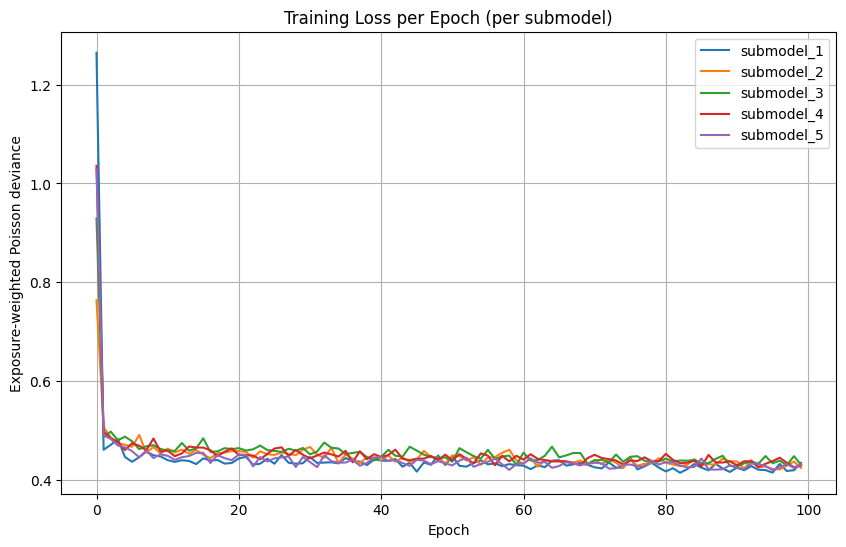

In [53]:
#elasticnet test
model = PoissonNN(input_dim=N, output_dim=M)
elastictrainer = PoissonTrainer(model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=32, n_layers=1), n_epochs=100, lr=1e-2, sub_frac=0.1, n_estimatiors=5)
elastictrainer.regularizer = 'elasticnet'
elastictrainer.alpha = 0.01
elastictrainer.l1_ratio = 0.9  # Set l1 ratio for elastic net
elastictrainer.train(X_train_tensor, y_train_tensor, exposure_train_tensor)
elastictrainer.evaluate(X_train_tensor, y_train_tensor, exposure_train_tensor,
                         X_test_tensor, y_test_tensor, exposure_test_tensor, verbose=True)
elastictrainer.plot_losses()

In [61]:
# Example weight_decay values to test for L2
weight_decays = [0.001, 0.01, 0.1, 1.0]
# L1 Regularizers to test
l1_values =  [0.001, 0.01, 0.1, 1.0]
# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results for each weight_decay
cv_results_l2 = {}
cv_results_l1 = {}

# Convert tensors to numpy for indexing
X_np = X_train_tensor.cpu().numpy()
y_np = y_train_tensor.cpu().numpy()
exp_np = exposure_train_tensor.cpu().numpy()

for l1_val, wd in zip(l1_values, weight_decays):
    print(f"\n=== Testing weight_decay={wd} === and l1 regularizer={l1_val} ===")
    
    fold_metrics_l2 = []
    fold_metrics_l1 = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"\n--- Fold {fold+1}/{n_splits} ---")
        
        # Create fold tensors
        X_train_fold = torch.tensor(X_np[train_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_train_fold = torch.tensor(y_np[train_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_train_fold = torch.tensor(exp_np[train_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)
        
        X_val_fold = torch.tensor(X_np[val_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_val_fold = torch.tensor(y_np[val_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_val_fold = torch.tensor(exp_np[val_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)
        
        # Create trainer
        trainer_l2 = PoissonTrainer(model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=32, n_layers=1), n_epochs=100, lr=1e-2, sub_frac=0.1, n_estimatiors=5)
        trainer_l2.lam_2 = wd

        trainer_l1 = PoissonTrainer(model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=32, n_layers=1), n_epochs=100, lr=1e-2, sub_frac=0.1, n_estimatiors=5)
        trainer_l1.lam_1 = l1_val
        # Train
        trainer_l2.train(X_train_fold, y_train_fold, exp_train_fold)
        trainer_l1.train(X_train_fold, y_train_fold, exp_train_fold)
        
        # Evaluate on validation fold
        metrics_l2 = trainer_l2.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )
        # Evaluate on validation fold
        metrics_l1 = trainer_l1.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )
        
        fold_metrics_l2.append(metrics_l2['test'])  # store test (validation) metrics
        fold_metrics_l1.append(metrics_l1['test'])  # store test (validation) metrics
        
        # Free GPU
        # trainer.free_gpu()
    
    # Average metrics across folds
    avg_metrics_l2 = {
        "mae": np.mean([m['mae'] for m in fold_metrics_l2]),
        "mse": np.mean([m['mse'] for m in fold_metrics_l2]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics_l2]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics_l2])
    }

       # Average metrics across folds
    avg_metrics_l1 = {
        "mae": np.mean([m['mae'] for m in fold_metrics_l1]),
        "mse": np.mean([m['mse'] for m in fold_metrics_l1]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics_l1]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics_l1])
    }
    
    cv_results_l2[wd] = avg_metrics_l2
    cv_results_l1[l1_val] = avg_metrics_l1
    # print(f"\nAverage metrics for weight_decay={wd}: {avg_metrics_l2}")

print("\n=== Cross-validation complete ===")



=== Testing weight_decay=0.001 === and l1 regularizer=0.001 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 101.42it/s, loss=0.44]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 105.35it/s, loss=0.449]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 106.80it/s, loss=0.456]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 103.85it/s, loss=0.419]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 105.16it/s, loss=0.441]



[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 68.12it/s, loss=0.448]



[Training submodel 2/5]


100%|██████████| 100/100 [00:02<00:00, 43.75it/s, loss=0.452]



[Training submodel 3/5]


100%|██████████| 100/100 [00:01<00:00, 69.68it/s, loss=0.451]



[Training submodel 4/5]


100%|██████████| 100/100 [00:01<00:00, 85.98it/s, loss=0.426]



[Training submodel 5/5]


100%|██████████| 100/100 [00:01<00:00, 99.83it/s, loss=0.444]



--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 97.79it/s, loss=0.449]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 104.48it/s, loss=0.442]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 100.94it/s, loss=0.452]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 109.06it/s, loss=0.444]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 106.25it/s, loss=0.452]



[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 99.25it/s, loss=0.444]



[Training submodel 2/5]


100%|██████████| 100/100 [00:01<00:00, 99.39it/s, loss=0.45] 



[Training submodel 3/5]


100%|██████████| 100/100 [00:01<00:00, 81.00it/s, loss=0.441]



[Training submodel 4/5]


100%|██████████| 100/100 [00:01<00:00, 78.74it/s, loss=0.444]



[Training submodel 5/5]


100%|██████████| 100/100 [00:01<00:00, 96.80it/s, loss=0.431]



--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 94.21it/s, loss=0.448]



[Training submodel 2/5]


100%|██████████| 100/100 [00:01<00:00, 94.30it/s, loss=0.433]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 101.81it/s, loss=0.431]



[Training submodel 4/5]


100%|██████████| 100/100 [00:01<00:00, 78.16it/s, loss=0.438]



[Training submodel 5/5]


100%|██████████| 100/100 [00:01<00:00, 59.43it/s, loss=0.442]



[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 53.14it/s, loss=0.438]



[Training submodel 2/5]


100%|██████████| 100/100 [00:01<00:00, 68.24it/s, loss=0.442]



[Training submodel 3/5]


100%|██████████| 100/100 [00:01<00:00, 72.56it/s, loss=0.444]



[Training submodel 4/5]


100%|██████████| 100/100 [00:01<00:00, 77.63it/s, loss=0.44]



[Training submodel 5/5]


100%|██████████| 100/100 [00:01<00:00, 79.69it/s, loss=0.444]



--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:01<00:00, 76.86it/s, loss=0.441]



[Training submodel 2/5]


100%|██████████| 100/100 [00:01<00:00, 88.25it/s, loss=0.441]



[Training submodel 3/5]


100%|██████████| 100/100 [00:03<00:00, 27.03it/s, loss=0.446]



[Training submodel 4/5]


100%|██████████| 100/100 [00:04<00:00, 23.19it/s, loss=0.442]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 104.40it/s, loss=0.455]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 120.48it/s, loss=0.452]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 116.05it/s, loss=0.443]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 112.86it/s, loss=0.464]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 112.30it/s, loss=0.448]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 115.10it/s, loss=0.446]



--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 109.43it/s, loss=0.442]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.49it/s, loss=0.431]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 110.62it/s, loss=0.439]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 115.66it/s, loss=0.455]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 124.88it/s, loss=0.457]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 120.19it/s, loss=0.448]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 119.73it/s, loss=0.449]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 114.59it/s, loss=0.452]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 114.55it/s, loss=0.448]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 114.42it/s, loss=0.445]



=== Testing weight_decay=0.01 === and l1 regularizer=0.01 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.37it/s, loss=0.454]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 114.16it/s, loss=0.437]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 116.15it/s, loss=0.439]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 120.91it/s, loss=0.447]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 123.17it/s, loss=0.455]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 117.53it/s, loss=0.429]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 119.62it/s, loss=0.449]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 121.73it/s, loss=0.443]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 121.01it/s, loss=0.465]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 118.60it/s, loss=0.439]



--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 118.75it/s, loss=0.447]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.14it/s, loss=0.429]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 121.11it/s, loss=0.453]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 120.39it/s, loss=0.447]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 114.09it/s, loss=0.461]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 118.67it/s, loss=0.447]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.93it/s, loss=0.422]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 121.19it/s, loss=0.456]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 120.50it/s, loss=0.436]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 120.51it/s, loss=0.438]



--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.53it/s, loss=0.445]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 116.88it/s, loss=0.442]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 120.46it/s, loss=0.447]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 115.25it/s, loss=0.437]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 116.67it/s, loss=0.457]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 113.83it/s, loss=0.445]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 116.07it/s, loss=0.452]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 116.58it/s, loss=0.452]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 115.96it/s, loss=0.446]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 115.27it/s, loss=0.444]



--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 112.94it/s, loss=0.466]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 117.23it/s, loss=0.454]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 116.46it/s, loss=0.443]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 118.87it/s, loss=0.449]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 117.06it/s, loss=0.451]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 120.47it/s, loss=0.45]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.71it/s, loss=0.448]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 120.85it/s, loss=0.445]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 119.22it/s, loss=0.442]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 116.26it/s, loss=0.442]



--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.96it/s, loss=0.454]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.95it/s, loss=0.452]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 120.29it/s, loss=0.441]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 116.95it/s, loss=0.436]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 117.61it/s, loss=0.446]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 118.10it/s, loss=0.453]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 111.67it/s, loss=0.452]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 119.37it/s, loss=0.458]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 121.01it/s, loss=0.441]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 113.57it/s, loss=0.448]



=== Testing weight_decay=0.1 === and l1 regularizer=0.1 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 121.61it/s, loss=0.426]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 127.62it/s, loss=0.443]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 119.76it/s, loss=0.451]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 112.55it/s, loss=0.445]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 118.13it/s, loss=0.45]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.48it/s, loss=0.435]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 115.05it/s, loss=0.454]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 117.37it/s, loss=0.441]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 113.22it/s, loss=0.447]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 116.04it/s, loss=0.452]



--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 111.29it/s, loss=0.464]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 112.55it/s, loss=0.442]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 113.23it/s, loss=0.441]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 115.79it/s, loss=0.457]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 119.23it/s, loss=0.452]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.35it/s, loss=0.44]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.08it/s, loss=0.461]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 115.65it/s, loss=0.455]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 114.32it/s, loss=0.439]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 115.28it/s, loss=0.442]



--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 107.82it/s, loss=0.442]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 114.26it/s, loss=0.446]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 120.72it/s, loss=0.435]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 116.93it/s, loss=0.432]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 111.86it/s, loss=0.451]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 113.53it/s, loss=0.444]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 113.26it/s, loss=0.438]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 110.48it/s, loss=0.442]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 112.81it/s, loss=0.434]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 112.40it/s, loss=0.435]



--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 108.62it/s, loss=0.449]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 109.30it/s, loss=0.437]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 108.59it/s, loss=0.448]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 117.38it/s, loss=0.453]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 117.01it/s, loss=0.429]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 118.11it/s, loss=0.449]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 118.92it/s, loss=0.447]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 118.94it/s, loss=0.453]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 111.16it/s, loss=0.45]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 121.20it/s, loss=0.457]



--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.96it/s, loss=0.467]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 120.14it/s, loss=0.45]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 118.11it/s, loss=0.434]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 106.93it/s, loss=0.438]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 114.94it/s, loss=0.433]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 114.76it/s, loss=0.451]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 113.76it/s, loss=0.438]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 112.73it/s, loss=0.451]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 115.02it/s, loss=0.456]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 111.23it/s, loss=0.432]



=== Testing weight_decay=1.0 === and l1 regularizer=1.0 ===

--- Fold 1/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 113.80it/s, loss=0.431]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 113.12it/s, loss=0.44]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 113.30it/s, loss=0.437]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 116.40it/s, loss=0.436]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 110.42it/s, loss=0.448]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 113.88it/s, loss=0.444]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 115.65it/s, loss=0.461]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 113.28it/s, loss=0.446]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 115.87it/s, loss=0.456]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 116.25it/s, loss=0.45]



--- Fold 2/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 115.56it/s, loss=0.429]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 109.26it/s, loss=0.447]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 116.65it/s, loss=0.441]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 114.89it/s, loss=0.444]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 114.91it/s, loss=0.446]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 113.58it/s, loss=0.429]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 116.39it/s, loss=0.44]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 109.85it/s, loss=0.429]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 110.61it/s, loss=0.453]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 115.54it/s, loss=0.446]



--- Fold 3/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 115.14it/s, loss=0.455]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 114.00it/s, loss=0.443]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 112.01it/s, loss=0.443]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 118.85it/s, loss=0.442]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 121.55it/s, loss=0.445]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 117.98it/s, loss=0.444]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 119.90it/s, loss=0.439]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 118.16it/s, loss=0.443]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 119.41it/s, loss=0.448]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 121.64it/s, loss=0.447]



--- Fold 4/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 121.97it/s, loss=0.466]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 116.60it/s, loss=0.437]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 118.82it/s, loss=0.423]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 114.95it/s, loss=0.458]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 113.30it/s, loss=0.458]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 115.30it/s, loss=0.447]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 116.71it/s, loss=0.46]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 114.05it/s, loss=0.453]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 113.50it/s, loss=0.439]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 107.94it/s, loss=0.44]



--- Fold 5/5 ---
[INFO] Using device: cuda
[INFO] Using device: cuda

[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 116.73it/s, loss=0.442]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 106.49it/s, loss=0.457]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 109.61it/s, loss=0.463]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 111.61it/s, loss=0.433]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 107.39it/s, loss=0.439]



[Training submodel 1/5]


100%|██████████| 100/100 [00:00<00:00, 110.24it/s, loss=0.44]



[Training submodel 2/5]


100%|██████████| 100/100 [00:00<00:00, 111.12it/s, loss=0.446]



[Training submodel 3/5]


100%|██████████| 100/100 [00:00<00:00, 110.01it/s, loss=0.46]



[Training submodel 4/5]


100%|██████████| 100/100 [00:00<00:00, 108.44it/s, loss=0.445]



[Training submodel 5/5]


100%|██████████| 100/100 [00:00<00:00, 112.39it/s, loss=0.442]



=== Cross-validation complete ===


In [56]:


# Display all cross-validation results
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS - ALL WEIGHT_DECAY VALUES")
print("="*60)

for wd, metrics in cv_results_l2.items():
    print(f"\nweight_decay = {wd}:")
    print(f"  {metrics}")

for l1_val, metrics in cv_results_l1.items():
    print(f"\nlasso regularizer = {l1_val}:")
    print(f"  {metrics}")




CROSS-VALIDATION RESULTS - ALL WEIGHT_DECAY VALUES

weight_decay = 0.001:
  {'mae': np.float64(0.1376020759344101), 'mse': np.float64(0.2352648764848709), 'dev_sklearn': np.float64(0.45800488591194155), 'dev_torch': np.float64(0.45800489783287046)}

weight_decay = 0.01:
  {'mae': np.float64(0.13679008781909943), 'mse': np.float64(0.23530995845794678), 'dev_sklearn': np.float64(0.4582937598228455), 'dev_torch': np.float64(0.45829376578330994)}

weight_decay = 0.1:
  {'mae': np.float64(0.13668998777866365), 'mse': np.float64(0.2354283004999161), 'dev_sklearn': np.float64(0.4588305473327637), 'dev_torch': np.float64(0.4588305473327637)}

weight_decay = 1.0:
  {'mae': np.float64(0.13755096793174743), 'mse': np.float64(0.23539267778396605), 'dev_sklearn': np.float64(0.4586572587490082), 'dev_torch': np.float64(0.4586572289466858)}

lasso regularizer = 0.001:
  {'mae': np.float64(0.13686102330684663), 'mse': np.float64(0.23524567782878875), 'dev_sklearn': np.float64(0.45744988322257996), 'd

In [ ]:
# cross validate elasticnet

from itertools import product
import numpy as np
import torch
from sklearn.model_selection import KFold

# Elastic Net hyperparameter grid
alphas = [0.001, 0.005, 0.01, 0.1, 1.0]
l1_ratios = [0.1, 0.5, 0.75, 0.9, 0.95]  # 0=L2, 1=L1

# CV setup
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storage
cv_results_elasticnet = {}

# Convert tensors to numpy for indexing
X_np = X_train_tensor.cpu().numpy()
y_np = y_train_tensor.cpu().numpy()
exp_np = exposure_train_tensor.cpu().numpy()

for alpha, l1_ratio in product(alphas, l1_ratios):

    print(f"\n=== Elastic Net: alpha={alpha}, l1_ratio={l1_ratio} ")

    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np)):
        print(f"--- Fold {fold+1}/{n_splits} ---")

        # Fold tensors
        X_train_fold = torch.tensor(X_np[train_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_train_fold = torch.tensor(y_np[train_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_train_fold = torch.tensor(exp_np[train_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)

        X_val_fold = torch.tensor(X_np[val_idx], dtype=X_train_tensor.dtype, device=DEVICE)
        y_val_fold = torch.tensor(y_np[val_idx], dtype=y_train_tensor.dtype, device=DEVICE)
        exp_val_fold = torch.tensor(exp_np[val_idx], dtype=exposure_train_tensor.dtype, device=DEVICE)

        # Model + Trainer
        trainer = PoissonTrainer(model_factory=lambda input_dim, output_dim, nn=n_neuron, nl=n_layers: poisson_model_factory(input_dim, output_dim, n_neurons_per_layer=32, n_layers=1), n_epochs=100, lr=1e-2, sub_frac=0.1, n_estimatiors=5)
        trainer.regularizer = 'elasticnet'
        trainer.alpha = alpha
        trainer.l1_ratio = l1_ratio

        # Train
        trainer.train(X_train_fold, y_train_fold, exp_train_fold)

        # Validate
        metrics = trainer.evaluate(
            X_train_fold, y_train_fold, exp_train_fold,
            X_val_fold, y_val_fold, exp_val_fold
        )

        fold_metrics.append(metrics['test'])

    # Average across folds
    avg_metrics = {
        "mae": np.mean([m['mae'] for m in fold_metrics]),
        "mse": np.mean([m['mse'] for m in fold_metrics]),
        "dev_sklearn": np.mean([m['dev_sklearn'] for m in fold_metrics]),
        "dev_torch": np.mean([m['dev_torch'] for m in fold_metrics]),
    }

    cv_results_elasticnet[(alpha, l1_ratio)] = avg_metrics

print("\n=== Elastic Net Grid Search Complete ===")



=== Elastic Net: alpha=0.001, l1_ratio=0.1 
--- Fold 1/5 ---


TypeError: PoissonTrainer.__init__() got an unexpected keyword argument 'model'

In [28]:
print("\nElastic Net CV Results")
print("-" * 70)
print(f"{'alpha':>8} {'l1_ratio':>10} {'MAE':>10} {'MSE':>10} {'Dev(SKL)':>12} {'Dev(Torch)':>12}")
print("-" * 70)

for (alpha, l1_ratio), m in cv_results_elasticnet.items():
    print(
        f"{alpha:8.4f} "
        f"{l1_ratio:10.2f} "
        f"{m['mae']:10.4f} "
        f"{m['mse']:10.4f} "
        f"{m['dev_sklearn']:12.4f} "
        f"{m['dev_torch']:12.4f}"
    )

print("-" * 70)



Elastic Net CV Results
----------------------------------------------------------------------
   alpha   l1_ratio        MAE        MSE     Dev(SKL)   Dev(Torch)
----------------------------------------------------------------------
  0.0010       0.10     0.0846     0.2418       0.9205       0.9205
  0.0010       0.50     0.0883     0.2414       0.8153       0.8153
  0.0010       0.75     0.0909     0.2414       0.8063       0.8063
  0.0010       0.88     0.0890     0.2409       0.7784       0.7784
  0.0010       1.00     0.0880     0.2419       0.8662       0.8662
  0.0100       0.10     0.0953     0.2411       0.7084       0.7084
  0.0100       0.50     0.1111     0.2408       0.5953       0.5953
  0.0100       0.75     0.1135     0.2399       0.5673       0.5673
  0.0100       0.88     0.1215     0.2405       0.5507       0.5507
  0.0100       1.00     0.1241     0.2405       0.5466       0.5466
  0.1000       0.10     0.1678     0.2408       0.4960       0.4960
  0.1000       0.5

# Exercise 3 (Tree-based methods)

### Question 3.a

In [ ]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [ ]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [ ]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets